In [2]:
edge_df = pd.read_parquet("./parquet/edge_df.parquet")

In [3]:
# ------------------------------------------------------------
# 4. TOP PLAYER INTERACTION METRICS
# ------------------------------------------------------------
# assists out degree
assist_edges = edge_df[edge_df["interaction"]=="assist"]

assist_counts = assist_edges.groupby("source").size().sort_values(ascending=False).head(20)
print("Top passers (by assists detected):")
print(assist_counts)

# steals
steal_edges = edge_df[edge_df["interaction"]=="steal"]
steal_counts = steal_edges.groupby("source").size().sort_values(ascending=False).head(20)

print("Top defensive ball thieves:")
print(steal_counts)

# blocks
block_edges = edge_df[edge_df["interaction"]=="block"]
block_counts = block_edges.groupby("source").size().sort_values(ascending=False).head(20)

print("Top shot blockers:")
print(block_counts)

Top passers (by assists detected):
source
Vince Carter         167
Ish Smith            155
Rajon Rondo          151
LeBron James         147
D.J. Augustin        143
Andre Miller         140
Jeff Green           136
Jamal Crawford       133
Trevor Ariza         131
Carmelo Anthony      130
Mike James           129
Richard Jefferson    129
Mike Miller          129
Mo Williams          128
Juwan Howard         128
Jose Calderon        127
Ramon Sessions       126
Lou Williams         125
James Johnson        125
Steve Nash           124
dtype: int64
Top defensive ball thieves:
source
Chris Paul           652
LeBron James         618
Kobe Bryant          591
Jason Kidd           573
Andre Iguodala       557
Thaddeus Young       555
Jason Terry          547
Manu Ginobili        542
Kevin Garnett        541
Vince Carter         536
Trevor Ariza         535
Paul Pierce          535
Kyle Lowry           515
Dwyane Wade          515
Allen Iverson        509
Russell Westbrook    508
Ray Allen 

In [4]:
# ============================================================
# CORRECT POSSESSION SCORING LOGIC
# ============================================================

def points_from_event(row):
    # not a scoring event
    if row.event_class != "shot_make":
        return 0

    desc = str(row.homedescription) + " " + str(row.visitordescription)
    desc_lower = desc.lower()

    # --- 3 POINT SHOTS ---
    if "3pt" in desc_lower or "3-pt" in desc_lower or "three" in desc_lower:
        return 3

    # --- FREE THROWS SCORED ---
    # For makes: event_class == shot_make never triggers for free throws.
    # Free throws are event_class == free_throw.
    # So scoring free throws must be handled separately below.
    return 2  # default made shot = 2 points


def points_from_free_throw(row):
    # free throw events
    if row.event_class != "free_throw":
        return 0
    
    desc = str(row.homedescription) + " " + str(row.visitordescription)
    desc_lower = desc.lower()

    # only successful FTs count
    # NBA logs a make as: "Free Throw 1 of 2 (1 PTS)"
    if "(1 pts)" in desc_lower or "(1 pt)" in desc_lower or "free throw" in desc_lower and "miss" not in desc_lower:
        return 1
    
    return 0


# add the correct scoring columns
df["points_shot"] = df.apply(points_from_event, axis=1)
df["points_ft"]   = df.apply(points_from_free_throw, axis=1)

# TOTAL points from the event
df["points"] = df["points_shot"] + df["points_ft"]

# now compute possession totals correctly
poss_eff = df.groupby("possession_id")["points"].sum()

print("Possession scoring cleaned.")
print("Maximum points in any possession:", poss_eff.max())
print("Expected range: 0 – 5 or 6")



NameError: name 'df' is not defined

In [5]:
import matplotlib.pyplot as plt

In [19]:
# ============================================================
# CONFIGURATION
# ============================================================
TOP_STEALERS = 15            # focus on elite defenders
MAX_VICTIMS_PER_DEFENDER = 12  # cap clutter per defender
MIN_EDGE_WEIGHT = 1          # minimum steals to show edge
SHOW_EDGE_LABELS_THRESHOLD = 2  # only label edges with 2+ steals
# Layout configuration - experiment with these!
LAYOUT_TYPE = 'bipartite'  # Options: 'spring', 'kamada', 'custom_radial', 'shell', 'bipartite'
SPRING_K = 3.5                 # Higher = more spread (for spring layout)
SPRING_ITERATIONS = 100        # More iterations = better convergence

NETWORK STATISTICS
Total Nodes: 57
Total Edges: 180
Defenders: 15
Victims: 42

TOP 10 MOST STOLEN FROM:
  Al Harrington: 13 steals (by 13 defenders)
  Al Horford: 13 steals (by 13 defenders)
  Al Jefferson: 13 steals (by 13 defenders)
  Aaron Brooks: 11 steals (by 11 defenders)
  Aaron Gordon: 10 steals (by 10 defenders)
  Al-Farouq Aminu: 10 steals (by 10 defenders)
  Alec Burks: 9 steals (by 9 defenders)
  Aaron Williams: 8 steals (by 8 defenders)
  Aaron McKie: 7 steals (by 7 defenders)
  Al Thornton: 7 steals (by 7 defenders)

Using layout: bipartite


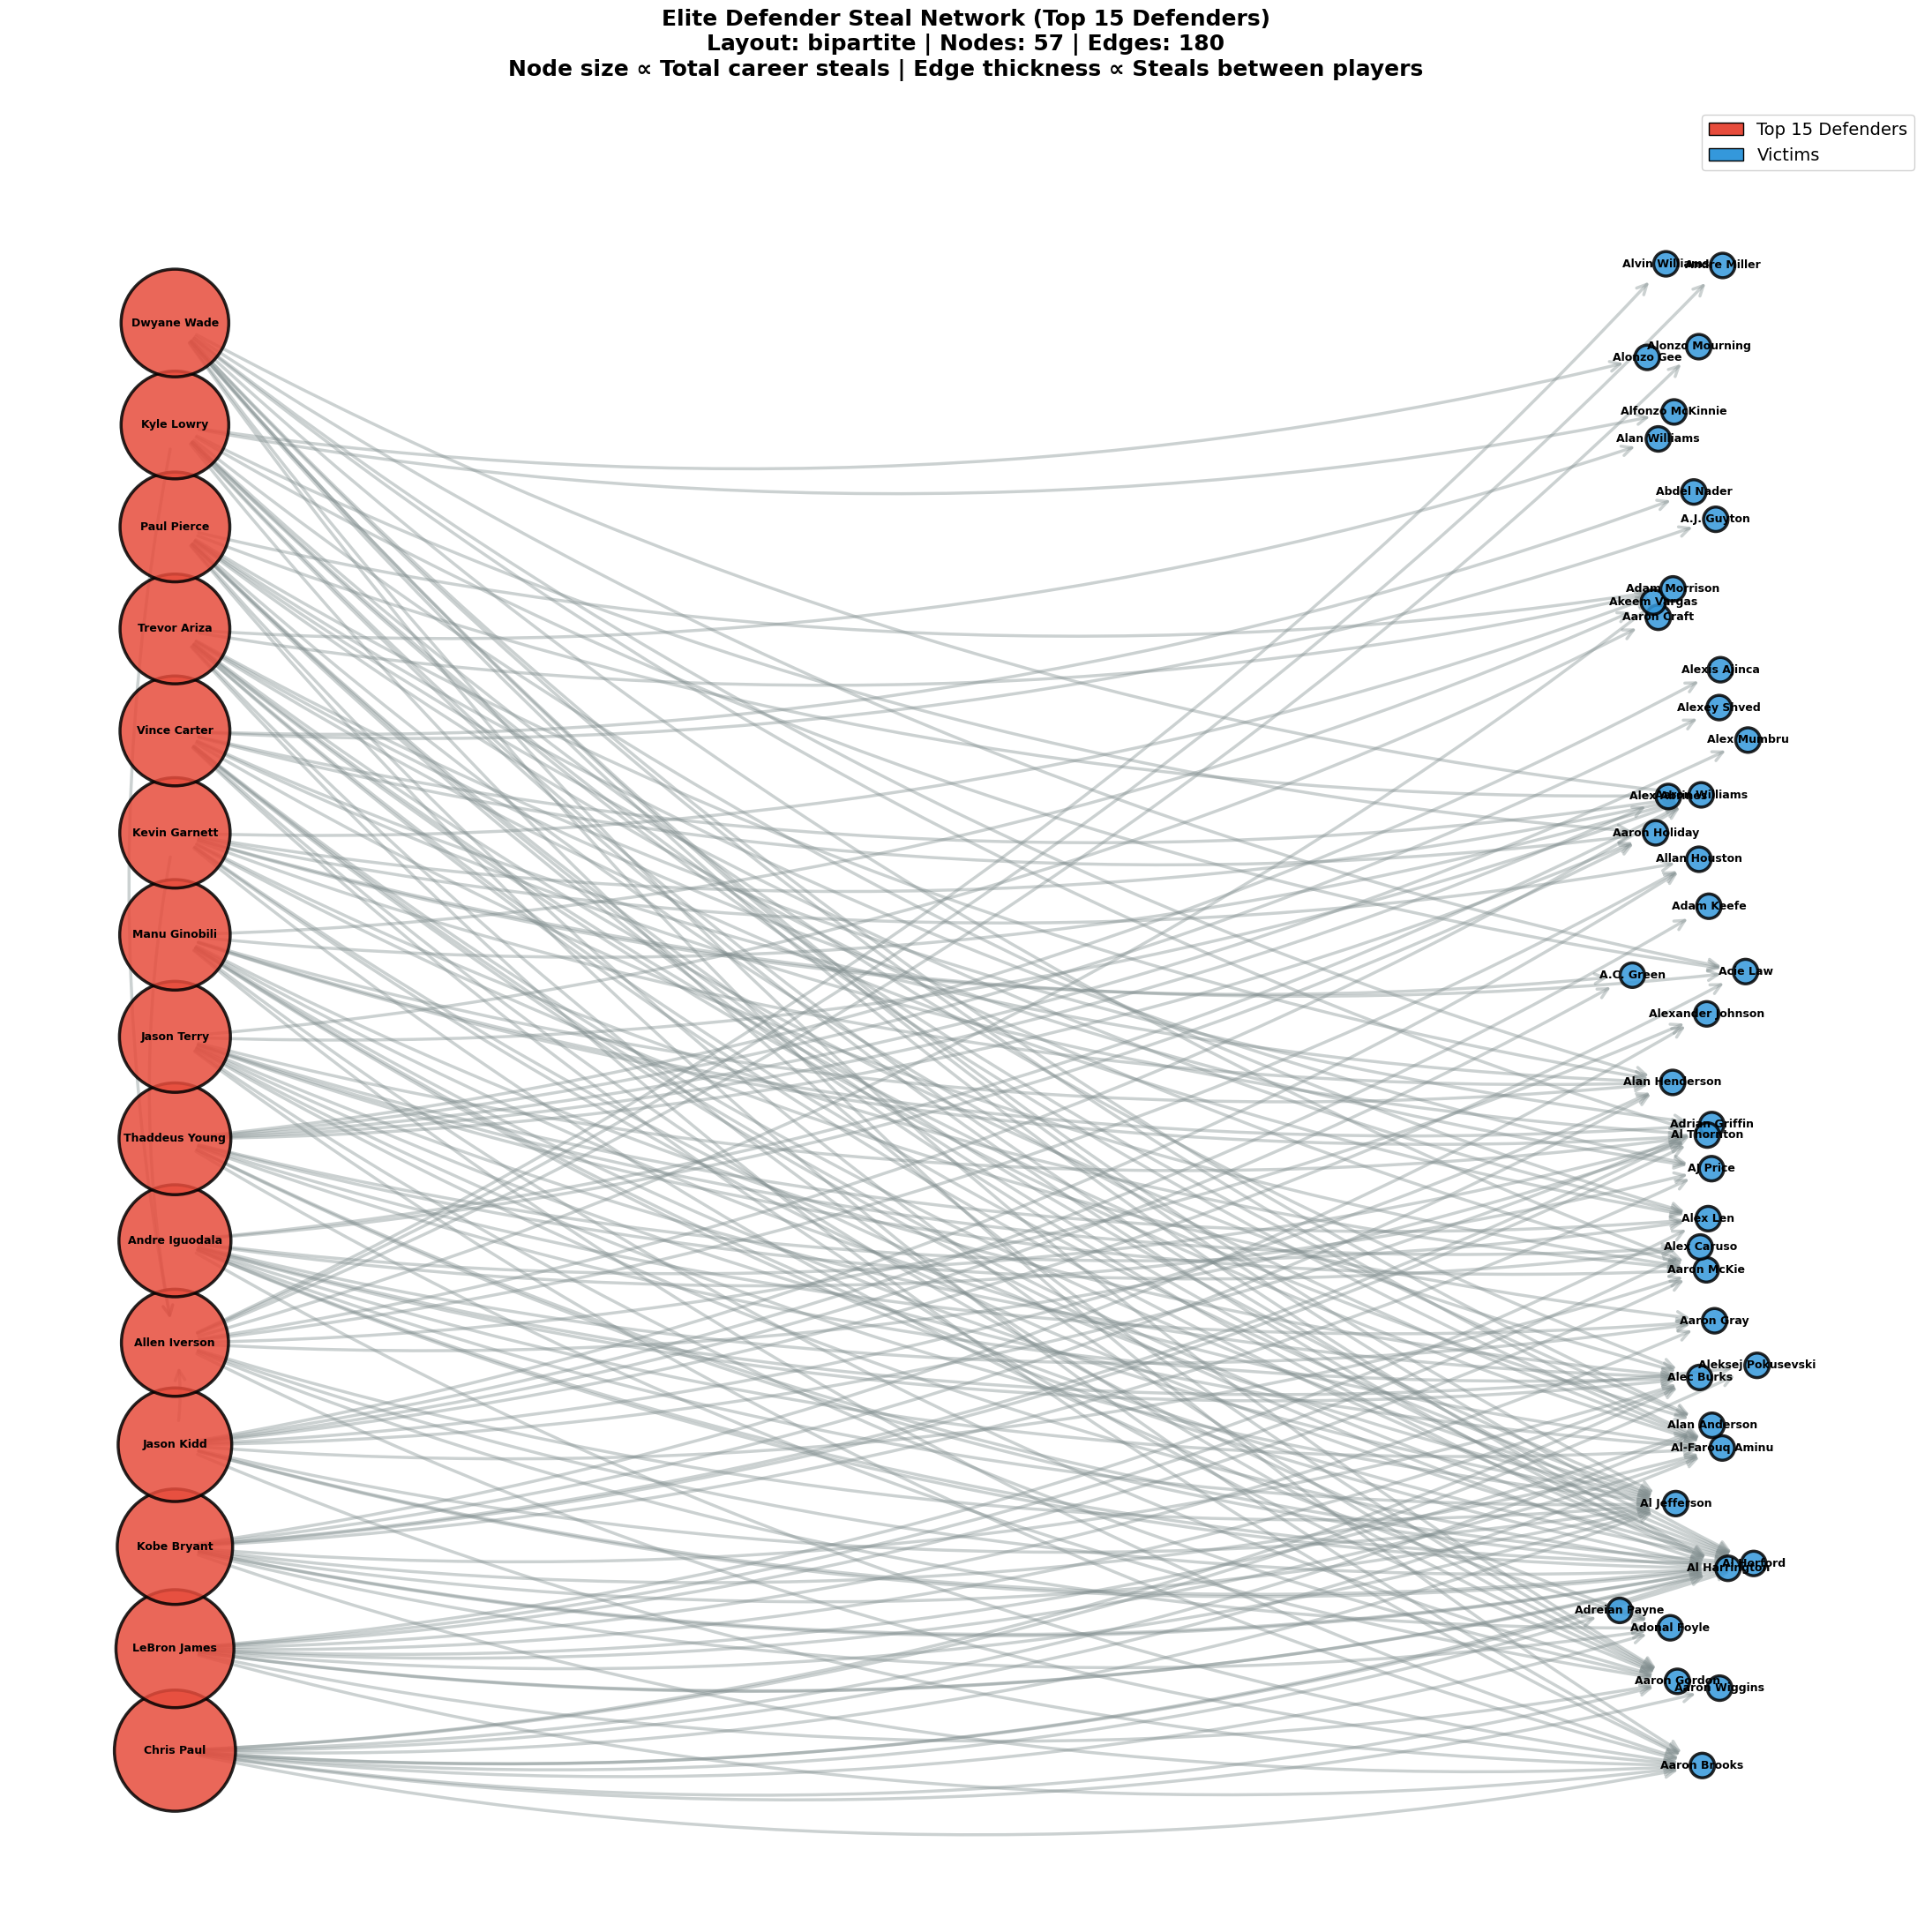


GENERATING INTERACTIVE VISUALIZATION...

✅ Interactive visualization saved as 'steal_network_bipartite_interactive.html'
✅ Static visualization saved as 'steal_network_bipartite.png'



TIP: Try different layouts by changing LAYOUT_TYPE:
  • 'custom_radial' - Defenders in outer ring (RECOMMENDED)
  • 'bipartite' - Defenders left, victims right
  • 'shell' - Multiple concentric shells
  • 'force_separated' - Force-directed with separation
  • 'spring' - Classic force-directed
  • 'kamada' - Kamada-Kawai algorithm


In [20]:
# ============================================================
# Enhanced Optimal Steal Network with Better Node Distribution
# ============================================================
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
import plotly.graph_objects as go
from matplotlib.patches import Patch
import numpy as np

# ============================================================
# CONFIGURATION
# ============================================================
# TOP_STEALERS = 15            # focus on elite defenders
# MAX_VICTIMS_PER_DEFENDER = 12  # cap clutter per defender
# MIN_EDGE_WEIGHT = 1          # minimum steals to show edge
# SHOW_EDGE_LABELS_THRESHOLD = 2  # only label edges with 2+ steals

# # Layout configuration - experiment with these!
# LAYOUT_TYPE = 'custom_radial'  # Options: 'spring', 'kamada', 'custom_radial', 'shell', 'bipartite'
# SPRING_K = 3.5                 # Higher = more spread (for spring layout)
# SPRING_ITERATIONS = 100        # More iterations = better convergence

# ============================================================
# DATA PREPARATION
# ============================================================
steal_edges = edge_df[edge_df["interaction"]=="steal"].copy()
top_defenders = steal_counts.head(TOP_STEALERS).index

# defender → victim grouped count
pair_counts = (
    steal_edges.groupby(["source","target"])
    .size()
    .reset_index(name="steal_count")
)

# keep only edges where source is top defender
pair_counts = pair_counts[pair_counts["source"].isin(top_defenders)]

# limit each defender to top 12 targets (reduces clutter)
filtered_pairs = []
for defender in top_defenders:
    df_def = pair_counts[pair_counts["source"] == defender]
    df_def = df_def.sort_values("steal_count", ascending=False).head(MAX_VICTIMS_PER_DEFENDER)
    filtered_pairs.append(df_def)

pair_counts = pd.concat(filtered_pairs, ignore_index=True)
pair_counts = pair_counts[pair_counts["steal_count"] >= MIN_EDGE_WEIGHT]

# ============================================================
# BUILD GRAPH
# ============================================================
G = nx.DiGraph()
for _, row in pair_counts.iterrows():
    G.add_edge(row["source"], row["target"], weight=row["steal_count"])

print("=" * 60)
print("NETWORK STATISTICS")
print("=" * 60)
print(f"Total Nodes: {len(G.nodes())}")
print(f"Total Edges: {len(G.edges())}")
print(f"Defenders: {len([n for n in G.nodes() if n in top_defenders])}")
print(f"Victims: {len([n for n in G.nodes() if n not in top_defenders])}")

# Most victimized players
victim_counts = dict(G.in_degree(weight='weight'))
print(f"\nTOP 10 MOST STOLEN FROM:")
for player, count in sorted(victim_counts.items(), key=lambda x: x[1], reverse=True)[:10]:
    defenders_count = G.in_degree(player)
    print(f"  {player}: {count} steals (by {defenders_count} defenders)")

# ============================================================
# CUSTOM LAYOUT ALGORITHMS TO PREVENT GROUPING
# ============================================================

def custom_radial_layout(G, top_defenders):
    """
    Place defenders in outer ring, victims in inner areas
    This prevents defender grouping
    """
    pos = {}
    
    defenders = [n for n in G.nodes() if n in top_defenders]
    victims = [n for n in G.nodes() if n not in top_defenders]
    
    # Place defenders in a circle
    n_defenders = len(defenders)
    for i, defender in enumerate(defenders):
        angle = 2 * np.pi * i / n_defenders
        radius = 10  # outer ring
        pos[defender] = (radius * np.cos(angle), radius * np.sin(angle))
    
    # Place victims in inner regions, clustered near their main defender
    for victim in victims:
        # Find which defenders steal from this victim
        stealing_defenders = list(G.predecessors(victim))
        
        if stealing_defenders:
            # Calculate average position of stealing defenders
            avg_angle = 0
            total_weight = 0
            
            for defender in stealing_defenders:
                if defender in pos:
                    defender_angle = np.arctan2(pos[defender][1], pos[defender][0])
                    weight = G[defender][victim]['weight']
                    avg_angle += defender_angle * weight
                    total_weight += weight
            
            if total_weight > 0:
                avg_angle /= total_weight
                
                # Add some randomness to prevent exact overlap
                angle_jitter = (np.random.random() - 0.5) * 0.3
                radius_jitter = np.random.random() * 2
                
                # Place victim closer to center, near their defenders
                inner_radius = 4 + radius_jitter
                pos[victim] = (
                    inner_radius * np.cos(avg_angle + angle_jitter),
                    inner_radius * np.sin(avg_angle + angle_jitter)
                )
        else:
            # Fallback for victims with no defenders
            angle = np.random.random() * 2 * np.pi
            radius = np.random.random() * 3 + 3
            pos[victim] = (radius * np.cos(angle), radius * np.sin(angle))
    
    return pos

def bipartite_style_layout(G, top_defenders):
    """
    Defenders on left, victims on right
    """
    pos = {}
    
    defenders = [n for n in G.nodes() if n in top_defenders]
    victims = [n for n in G.nodes() if n not in top_defenders]
    
    # Place defenders vertically on the left
    n_defenders = len(defenders)
    for i, defender in enumerate(defenders):
        y = (i - n_defenders/2) * 2
        x = -10
        pos[defender] = (x, y)
    
    # Place victims vertically on the right
    n_victims = len(victims)
    for i, victim in enumerate(victims):
        y = (i - n_victims/2) * (n_defenders * 2 / n_victims) if n_victims > 0 else 0
        x = 10
        # Add slight jitter
        pos[victim] = (x + np.random.randn() * 0.5, y + np.random.randn() * 0.3)
    
    return pos

def shell_layout_separated(G, top_defenders):
    """
    Multiple shells with defenders separated
    """
    defenders = [n for n in G.nodes() if n in top_defenders]
    victims = [n for n in G.nodes() if n not in top_defenders]
    
    # Create shells: defenders on outer shell, victims on inner shells
    shells = [defenders]
    
    # Divide victims into multiple shells by how many defenders steal from them
    victim_popularity = {v: G.in_degree(v) for v in victims}
    sorted_victims = sorted(victims, key=lambda v: victim_popularity[v], reverse=True)
    
    # Create 2-3 inner shells
    n_victims = len(sorted_victims)
    if n_victims > 0:
        shell_size = max(n_victims // 3, 1)
        for i in range(0, n_victims, shell_size):
            shells.append(sorted_victims[i:i+shell_size])
    
    return nx.shell_layout(G, shells)

def force_directed_separated(G, top_defenders):
    """
    Force-directed with initial positions to separate defenders
    """
    # Start with defenders evenly spaced
    initial_pos = {}
    defenders = [n for n in G.nodes() if n in top_defenders]
    victims = [n for n in G.nodes() if n not in top_defenders]
    
    n_defenders = len(defenders)
    for i, defender in enumerate(defenders):
        angle = 2 * np.pi * i / n_defenders
        initial_pos[defender] = np.array([15 * np.cos(angle), 15 * np.sin(angle)])
    
    # Place victims randomly in center
    for victim in victims:
        angle = np.random.random() * 2 * np.pi
        radius = np.random.random() * 5
        initial_pos[victim] = np.array([radius * np.cos(angle), radius * np.sin(angle)])
    
    # Run spring layout with initial positions
    return nx.spring_layout(G, pos=initial_pos, k=SPRING_K, iterations=SPRING_ITERATIONS, seed=42)

# ============================================================
# SELECT AND APPLY LAYOUT
# ============================================================
print(f"\nUsing layout: {LAYOUT_TYPE}")

if LAYOUT_TYPE == 'spring':
    pos = nx.spring_layout(G, k=SPRING_K, iterations=SPRING_ITERATIONS, seed=42)
elif LAYOUT_TYPE == 'kamada':
    pos = nx.kamada_kawai_layout(G)
elif LAYOUT_TYPE == 'custom_radial':
    pos = custom_radial_layout(G, top_defenders)
elif LAYOUT_TYPE == 'shell':
    pos = shell_layout_separated(G, top_defenders)
elif LAYOUT_TYPE == 'bipartite':
    pos = bipartite_style_layout(G, top_defenders)
elif LAYOUT_TYPE == 'force_separated':
    pos = force_directed_separated(G, top_defenders)
else:
    # Default fallback
    pos = nx.spring_layout(G, k=3.0, iterations=100, seed=42)

# ============================================================
# MATPLOTLIB VISUALIZATION
# ============================================================
plt.figure(figsize=(22, 22))

# Node sizing based on total steals
node_sizes = []
for node in G.nodes():
    size = steal_counts.get(node, 0) * 15
    node_sizes.append(max(size, 400))

# Color defenders vs victims differently
node_colors = ['#e74c3c' if node in top_defenders else '#3498db' 
               for node in G.nodes()]

# Edge weights
edge_weights = [G[u][v]["weight"] for u, v in G.edges()]
max_weight = max(edge_weights) if edge_weights else 1
min_weight = min(edge_weights) if edge_weights else 1

# Draw edges with curved arrows and scaled widths
if max_weight > min_weight:
    edge_widths = [0.5 + ((w - min_weight) / (max_weight - min_weight)) * 4.5 for w in edge_weights]
else:
    edge_widths = [2.5] * len(edge_weights)

nx.draw_networkx_edges(
    G, pos, 
    width=edge_widths,
    alpha=0.4,
    arrowsize=20,
    arrowstyle='->',
    connectionstyle='arc3,rad=0.1',
    edge_color='#7f8c8d',
    min_source_margin=20,
    min_target_margin=20
)

# Draw nodes
nx.draw_networkx_nodes(
    G, pos, 
    node_size=node_sizes, 
    node_color=node_colors, 
    alpha=0.85,
    edgecolors='black',
    linewidths=2.5
)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=9, font_weight='bold', font_family='sans-serif')

# Add edge labels for high-value connections only
edge_labels = {(u, v): f"{G[u][v]['weight']}" 
               for u, v in G.edges() if G[u][v]['weight'] >= SHOW_EDGE_LABELS_THRESHOLD}
if edge_labels:
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=8, 
                                  bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

# Add legend
legend_elements = [
    Patch(facecolor='#e74c3c', edgecolor='black', label=f'Top {TOP_STEALERS} Defenders'),
    Patch(facecolor='#3498db', edgecolor='black', label='Victims')
]
plt.legend(handles=legend_elements, loc='upper right', fontsize=14, framealpha=0.9)

# Title with statistics
plt.title(
    f"Elite Defender Steal Network (Top {TOP_STEALERS} Defenders)\n"
    f"Layout: {LAYOUT_TYPE} | Nodes: {len(G.nodes())} | Edges: {len(G.edges())}\n"
    f"Node size ∝ Total career steals | Edge thickness ∝ Steals between players", 
    fontsize=18, pad=25, fontweight='bold'
)

plt.axis("off")
plt.tight_layout()
plt.savefig(f'steal_network_{LAYOUT_TYPE}.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# ============================================================
# INTERACTIVE PLOTLY VISUALIZATION
# ============================================================
print("\n" + "=" * 60)
print("GENERATING INTERACTIVE VISUALIZATION...")
print("=" * 60)

# Create edge traces
edge_traces = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    weight = G[edge[0]][edge[1]]['weight']
    
    if max_weight > min_weight:
        scaled_width = 0.5 + ((weight - min_weight) / (max_weight - min_weight)) * 5
    else:
        scaled_width = 3
    
    edge_traces.append(go.Scatter(
        x=[x0, x1, None], 
        y=[y0, y1, None],
        mode='lines',
        line=dict(width=scaled_width, color='rgba(127, 140, 141, 0.5)'),
        hoverinfo='text',
        hovertext=f"<b>{edge[0]} → {edge[1]}</b><br>{weight} steal(s)",
        showlegend=False
    ))

# Create node trace
node_x = [pos[node][0] for node in G.nodes()]
node_y = [pos[node][1] for node in G.nodes()]
node_text = [node for node in G.nodes()]

# Prepare hover text
hover_texts = []
for node in G.nodes():
    total_steals = steal_counts.get(node, 0)
    is_defender = node in top_defenders
    
    if is_defender:
        out_degree = G.out_degree(node, weight='weight')
        victims = G.out_degree(node)
        in_degree = G.in_degree(node, weight='weight')
        
        hover_texts.append(
            f"<b>{node}</b> (DEFENDER)<br>"
            f"─────────────────<br>"
            f"Total Career Steals: {total_steals}<br>"
            f"Steals in Network: {out_degree}<br>"
            f"Victims Targeted: {victims}"
        )
    else:
        in_degree = G.in_degree(node, weight='weight')
        stolen_by = G.in_degree(node)
        
        hover_texts.append(
            f"<b>{node}</b> (VICTIM)<br>"
            f"─────────────────<br>"
            f"Total Career Steals: {total_steals}<br>"
            f"Stolen from: {in_degree} times<br>"
            f"By {stolen_by} defenders"
        )

plotly_node_colors = ['#e74c3c' if node in top_defenders else '#3498db' 
                      for node in G.nodes()]

plotly_node_sizes = []
for node in G.nodes():
    size = steal_counts.get(node, 0) * 0.2
    plotly_node_sizes.append(max(size, 20))

node_trace = go.Scatter(
    x=node_x, 
    y=node_y,
    mode='markers+text',
    text=node_text,
    textposition="top center",
    textfont=dict(size=10, color='black', family='Arial Black'),
    marker=dict(
        size=plotly_node_sizes,
        color=plotly_node_colors,
        line=dict(width=2, color='black'),
        opacity=0.9
    ),
    hovertext=hover_texts,
    hoverinfo='text',
    showlegend=False
)

fig = go.Figure(data=edge_traces + [node_trace])

fig.update_layout(
    title=dict(
        text=f"<b>Elite Defender Steal Network (Interactive)</b><br>"
             f"<sub>Layout: {LAYOUT_TYPE} | Top {TOP_STEALERS} Defenders</sub>",
        x=0.5,
        xanchor='center',
        font=dict(size=20)
    ),
    showlegend=False,
    width=1600,
    height=1600,
    hovermode='closest',
    plot_bgcolor='white',
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    annotations=[
        dict(
            text="🔴 Red = Defenders | 🔵 Blue = Victims<br>Hover for details | Drag to pan | Scroll to zoom",
            showarrow=False,
            xref="paper", yref="paper",
            x=0.5, y=-0.05,
            xanchor='center',
            font=dict(size=12)
        )
    ]
)

fig.write_html(f'steal_network_{LAYOUT_TYPE}_interactive.html')
print(f"\n✅ Interactive visualization saved as 'steal_network_{LAYOUT_TYPE}_interactive.html'")
print(f"✅ Static visualization saved as 'steal_network_{LAYOUT_TYPE}.png'")

fig.show()

print("\n" + "=" * 60)
print("TIP: Try different layouts by changing LAYOUT_TYPE:")
print("  • 'custom_radial' - Defenders in outer ring (RECOMMENDED)")
print("  • 'bipartite' - Defenders left, victims right")
print("  • 'shell' - Multiple concentric shells")
print("  • 'force_separated' - Force-directed with separation")
print("  • 'spring' - Classic force-directed")
print("  • 'kamada' - Kamada-Kawai algorithm")
print("=" * 60)